## Predicting Pulsars Using High Time Resolution Universe Survey Data

Here, we will use the High Time Resolution Universe Survey to predict whether or not a star is a pulsar. A pulsar is a rare type of neutron star whic generates emission beams. As the pulsar rotates, these beams sweep into and out of our line of sight at regular intervals, and so we are able to search for pulsars by looking for periodic signals with large radio telescopes. However, the data is often clouded by radio frequency interference and noise. To combat this, analysts have begun using classification systems to automatically label pulsar candidates. In this excercise we will be looking at a dataset with examples of both noise and pulsar stars (each checked by human annotators) in hopes of creating a system which differentiate between pulsars and noise. 

***This dataset is a good example for binary classification for which the two classes (signal and background) are imbalanced. Only 10% of the rows corresponds to the signal and the rest is simply background. You will have to research the techniques for handling imbalanced datasets and apply them to your model.***

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore') 

import matplotlib.pyplot as plt
import seaborn as sns # Comment this if seaborn is not installed
%matplotlib inline

path = 'data/'
df = pd.read_csv(path + 'pulsar_stars.csv')

df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [2]:
df.shape

(17898, 9)

Let us check if there are any missing values in the dataset using [`isnull()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html) and [`sum()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html) functions piped one after the other.

In [3]:
df.isnull().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

No missing values in the dataset!

Let us check the different columns in the dataset.

In [5]:
df.columns

Index([' Mean of the integrated profile',
       ' Standard deviation of the integrated profile',
       ' Excess kurtosis of the integrated profile',
       ' Skewness of the integrated profile', ' Mean of the DM-SNR curve',
       ' Standard deviation of the DM-SNR curve',
       ' Excess kurtosis of the DM-SNR curve', ' Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')

These columns have a lot of jargon, but we can briefly explain the analysis process for a pulsar. Pulsar signals are often too weak to detect, and so we "fold", or integrate, these signals with respect to the rotational period in order to look at the data modulo the period. This will give us an amplified signal-to-noise ratio, similar to the figure below: 
<img src="http://inspirehep.net/record/1610824/files/J0437-4715_N.png" width="400"/>
Looking at the image of an intefrated profile, we can see that the mean and the standard deviation help us to determine the phase and duration of the pulsar signal. Additionally, looking at the skewness will measure the symmetry of the peak about the mean, and looking at the kurtosis (a measure of the central tendency of the distribution) will allow us to determine the number of samples in the tails.

We will also be looking at the DM-SNR, or 'dispersion measure signal-to-noise ratio' curve. As the pulses interact with material in the interstellar medium, lower frequency pulses arrive later than higher frequency pulses.

<img src="http://www.jb.man.ac.uk/distance/frontiers/pulsars/disp2.gif" width="300"/>

While astronomers will fit the shape of their signal to compensate, there is always some error associated with this, which is characterized in the DM-SNR curve.

<img src="https://allofyourbases.files.wordpress.com/2019/03/dm_snr.png" width="400"/>

The same metrics can be used to classify the characteristics of this curve (mean, standard deviation, kurtosis, and skewness) as before. 

This gives us a total of eight variables to look at:

<img src="https://allofyourbases.files.wordpress.com/2019/03/pulsar_features.png" width="400"/>

Let us first trim the names of the columns.

In [6]:
feature_names = ['Mean_IP', 'STD_IP','Kurt_IP', 'Skew_IP',
                 'Mean_DM', 'STD_DM','Kurt_DM', 'Skew_DM', 'Class']
df.columns = feature_names
df.head()

,Mean_IP,STD_IP,Kurt_IP,Skew_IP,Mean_DM,STD_DM,Kurt_DM,Skew_DM,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Now we want to check whether or not this dataset is imbalanced, or if it has roughly the same number of pulsar examples as noise examples

In [7]:
df['Class'].value_counts()

0    16259
1     1639
Name: Class, dtype: int64

We can represent this as a pie chart to get a better look at the distribution.

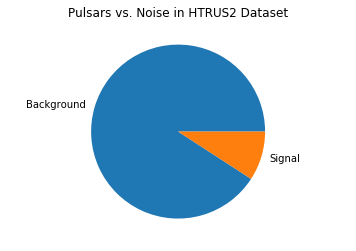

In [8]:
plt.axis('equal') 
plt.title("Pulsars vs. Noise in HTRUS2 Dataset")
plt.pie(df['Class'].value_counts(), labels=('Background', 'Signal'));

We can see that our signal, or true pulsars, is largely burried in background noise, which we might want to consider when making our classifier.

Let us check the datatypes of all the columns using [`dtypes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html).

In [9]:
df.dtypes

Mean_IP    float64
STD_IP     float64
Kurt_IP    float64
Skew_IP    float64
Mean_DM    float64
STD_DM     float64
Kurt_DM    float64
Skew_DM    float64
Class        int64
dtype: object

Unlike last week, this dataset doesn't need any cleaning! All of the variables are numerical and there are no empty values. Now you are free to work on creating this classification algorithm on your own. The main goal of this miniproject is to create a classifier which can identify pulsars from background noise using the eight variables discussed. Please reach out to the instructor to ask for help/discuss.

At the end, make a copy of the notebook and clean it all up to present the analysis and model in a clear and coherent manner. It would be a great idea to share your work as a blog using [Github Pages](https://help.github.com/en/articles/what-is-github-pages).

As a reference:
* Mean: Gives us a reference for the  phase (IP) or signal-to-noise peak(DM)
* STD: Gives us a reference for the spread of the distribution
* Kurt: Kurtosis, Gives us a reference for the amount of data contained in the tails
* Skew: Gives us a reference for the symmetry about the peak


* IP: Integrated profile, contains information about the phase vs. intensity
* DM: Dispersion measure, contains information about the dispersion vs, signal-to-noise ratio


#### Acknowledgements:
The credits for the images used above are as follows.

* Image 1: http://inspirehep.net/record/1610824/plots
* Image 2: http://www.jb.man.ac.uk/distance/frontiers/pulsars/section4.html
* Image 3: https://as595.github.io/classification/
* Image 4: https://as595.github.io/classification/